# Inference in DDIM (Denoising Diffusion Implicit Models)

**Goals**

1. Present the DDIM sampling equation and how it generalizes DDPM.
2. Show the deterministic DDIM case ($\sigma_t=0$), explain unique invertibility and why it enables editing.
3. Implement forward noising and DDIM reverse sampling on MNIST.
4. Demonstrate exact invertibility when using the true noise (oracle) and contrast with an untrained noise predictor.
5. Provide clear printed steps and 2D/3D visualizations for intuition.


# DDIM: Definition and Derivation

**Forward diffusion (same as DDPM)**

For $t=1,\dots,T$ define a forward (noising) kernel
$$
q(x_t\mid x_0) = \mathcal{N}\big(x_t;\ \sqrt{\bar\alpha_t}\,x_0,\ (1-\bar\alpha_t)I\big),
\qquad
\bar\alpha_t=\prod_{s=1}^t\alpha_s,\ \alpha_s=1-\beta_s.
$$

A single-sample closed form is:
$$
x_t = \sqrt{\bar\alpha_t}\,x_0 + \sqrt{1-\bar\alpha_t}\,\epsilon,\qquad \epsilon\sim\mathcal{N}(0,I).
$$

**DDIM reverse update (general non-Markovian)**

Given a noise-predictor $\epsilon_\theta(x_t,t)$ and a chosen scalar $\sigma_t\ge0$,
a generalized sampling update is
$$
x_{t-1} = \sqrt{\bar\alpha_{t-1}}\,\hat x_0(x_t)
\;+\;\sqrt{1-\bar\alpha_{t-1}-\sigma_t^2}\,\epsilon_\theta(x_t,t)
\;+\;\sigma_t z,\qquad z\sim\mathcal{N}(0,I),
$$
where $\hat x_0(x_t)$ is reconstructed from the predicted noise by
$$
\hat x_0(x_t)=\frac{x_t-\sqrt{1-\bar\alpha_t}\,\epsilon_\theta(x_t,t)}{\sqrt{\bar\alpha_t}}.
$$

**Special cases / remarks**

- DDPM is a special case when $\sigma_t$ equals the posterior std (a particular choice).  
- Setting $\sigma_t=0$ yields a **deterministic** DDIM sampler:
  $$
  x_{t-1} = \sqrt{\bar\alpha_{t-1}}\,\hat x_0(x_t)
  + \sqrt{1-\bar\alpha_{t-1}}\,\epsilon_\theta(x_t,t).
  $$
- If $\epsilon_\theta$ is *exact* (oracle = true noise used to produce $x_t$), then with $\sigma_t=0$ the mapping becomes **uniquely invertible**: starting from $x_0$ produce $x_T$ with the forward formula and then deterministically recover $x_0$ by applying the reverse DDIM with the same oracle noise.
- Deterministic invertibility is useful for image editing: map an image to its latent noise, change conditioning, map back deterministically.


In [1]:
# Python: imports and device
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1MB/s]


Batch shape: torch.Size([8, 1, 28, 28]) Labels: [7, 2, 1, 0, 4, 1, 4, 9]


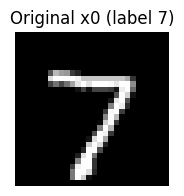

In [2]:
# Python: load MNIST and display one example
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # [-1,1] range
])

mnist = datasets.MNIST(root="mnist_data", train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=8, shuffle=False)

imgs, labs = next(iter(loader))
imgs = imgs.to(device)
print("Batch shape:", imgs.shape, "Labels:", labs.tolist())

# show first image (denormalized)
im = imgs[0].cpu().squeeze(0) * 0.5 + 0.5
plt.figure(figsize=(2,2))
plt.imshow(im, cmap='gray', vmin=0, vmax=1)
plt.title(f"Original x0 (label {int(labs[0])})")
plt.axis('off')
plt.show()


T: 50
beta[0], beta[-1]: 9.999999747378752e-05 0.019999999552965164
alpha_bars[0:5]: [0.9999     0.99939394 0.9984822  0.99716586 0.99544626]


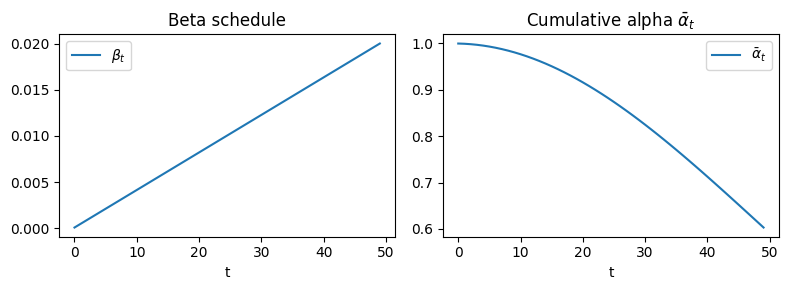

In [4]:
# Python: schedule
T = 50
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)  # shape (T,)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

print("T:", T)
print("beta[0], beta[-1]:", float(betas[0]), float(betas[-1]))
print("alpha_bars[0:5]:", alpha_bars[:5].cpu().numpy())

plt.figure(figsize=(8,3))

# -------------------------------
# Plot betas
# -------------------------------
plt.subplot(1,2,1)
plt.plot(betas.cpu().numpy(), label=r'$\beta_t$')
plt.title(r'Beta schedule')
plt.xlabel('t')
plt.legend()

# -------------------------------
# Plot alpha-bars
# -------------------------------
plt.subplot(1,2,2)
plt.plot(alpha_bars.cpu().numpy(), label=r'$\bar{\alpha}_t$')
plt.title(r'Cumulative alpha $\bar{\alpha}_t$')
plt.xlabel('t')
plt.legend()

plt.tight_layout()
plt.show()


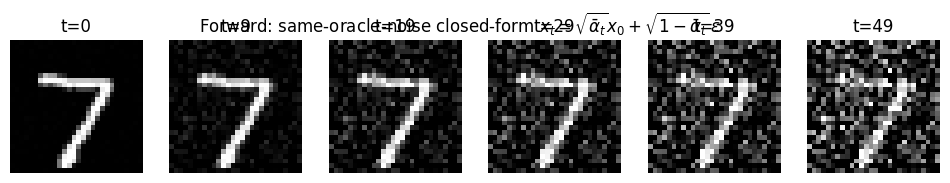

In [5]:
# Python: forward closed-form sampling q(x_t|x0)
def q_sample(x0, t, eps=None):
    """Return x_t = sqrt(abar_t)*x0 + sqrt(1-abar_t)*eps with same eps for all t (oracle style).
       x0: tensor (B,1,28,28), t: integer index in [0,T-1]
       eps: if None, sampled fresh and reused (shape like x0)
    """
    if eps is None:
        eps = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bars[t]).view(1,1,1,1).to(x0.device)
    sqrt_1_ab = torch.sqrt(1.0 - alpha_bars[t]).view(1,1,1,1).to(x0.device)
    return sqrt_ab * x0 + sqrt_1_ab * eps, eps

# choose an example x0
x0 = imgs[0:1]  # shape (1,1,28,28)
eps_oracle = torch.randn_like(x0)  # single oracle noise that will be used in closed form
# compute x_t for selected timesteps (same underlying eps)
timesteps = [0, 9, 19, 29, 39, 49]
noisy = []
for t in timesteps:
    x_t, _ = q_sample(x0, t, eps=eps_oracle)
    noisy.append((t, x_t.detach().cpu().squeeze().numpy()))

# plot
cols = len(noisy)
fig, axes = plt.subplots(1, cols, figsize=(2*cols,2))
for i, (t, arr) in enumerate(noisy):
    axes[i].imshow((arr+1)/2, cmap='gray', vmin=0, vmax=1)  # map from [-1,1] to [0,1]
    axes[i].set_title(f"t={t}")
    axes[i].axis('off')
plt.suptitle("Forward: same-oracle-noise closed-form $x_t = \\sqrt{\\bar\\alpha_t}x_0 + \\sqrt{1-\\bar\\alpha_t}\\,\\epsilon$")
plt.show()


# DDIM sampling (reminder)

The practical DDIM reverse update we use (general form) is:

$$
\hat x_0(x_t) = \frac{x_t - \sqrt{1-\bar\alpha_t}\,\epsilon_\theta(x_t,t)}{\sqrt{\bar\alpha_t}}
$$

$$
x_{t-1} = \sqrt{\bar\alpha_{t-1}}\,\hat x_0(x_t)
\;+\;\sqrt{1-\bar\alpha_{t-1}-\sigma_t^2}\,\epsilon_\theta(x_t,t)
\;+\;\sigma_t z,\quad z\sim\mathcal N(0,I).
$$

Deterministic DDIM uses $\sigma_t=0$:

$$
x_{t-1} = \sqrt{\bar\alpha_{t-1}}\,\hat x_0(x_t) + \sqrt{1-\bar\alpha_{t-1}}\,\epsilon_\theta(x_t,t).
$$


In [6]:
# Python: small untrained noise predictor (for demonstration only)
class SmallNoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )
    def forward(self, x, t=None):
        # real models use t-embeddings; we omit t-conditioning in this simple demo
        return self.net(x)

pred_model = SmallNoisePredictor().to(device)
pred_model.eval()

# helper: reconstruct x0_hat from predicted eps
def x0_from_eps_pred(x_t, eps_pred, t):
    numer = x_t - torch.sqrt(1.0 - alpha_bars[t]).view(1,1,1,1).to(x_t.device) * eps_pred
    denom = torch.sqrt(alpha_bars[t]).view(1,1,1,1).to(x_t.device)
    return numer / denom

# helper: DDIM deterministic step (sigma=0)
def ddim_step_deterministic(x_t, eps_pred, t, t_prev):
    # t_prev = t-1 index
    x0_hat = x0_from_eps_pred(x_t, eps_pred, t)
    out = torch.sqrt(alpha_bars[t_prev]).view(1,1,1,1).to(x_t.device) * x0_hat \
          + torch.sqrt(1.0 - alpha_bars[t_prev]).view(1,1,1,1).to(x_t.device) * eps_pred
    return out, x0_hat


Created x_T from x0 using oracle eps. x_T mean/std: -0.6423547863960266 0.7658692002296448
Recovered x0 mean/std: -0.8154918551445007 0.5178897976875305
Max absolute difference between original x0 and recovered x0 (oracle eps, deterministic DDIM): 3.339034e-02


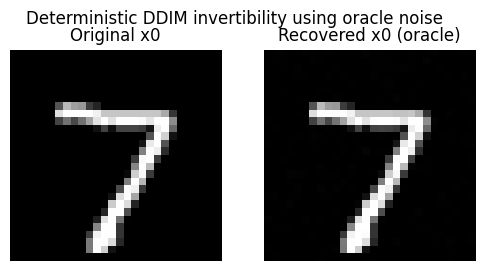

In [7]:
# Python: deterministic invertibility demonstration using oracle noise (eps_oracle)
# 1) Create x_T using oracle eps (already computed above)
t_T = timesteps[-1]  # e.g., 49
x_T, eps_used = q_sample(x0, t_T, eps=eps_oracle)  # x_T computed with oracle eps
x_current = x_T.clone()
print("Created x_T from x0 using oracle eps. x_T mean/std:", x_current.mean().item(), x_current.std().item())

# 2) Run deterministic DDIM reverse using *oracle* eps (i.e., epsilon_theta(x_t,t) = eps_oracle)
reconstructed = None
saved = []
for idx in reversed(range(1, t_T+1)):
    t = idx
    t_prev = idx - 1
    # Here we use the oracle eps corresponding to x_t (same eps_used)
    eps_pred = eps_used.to(x_current.device)
    x_prev, x0_hat = ddim_step_deterministic(x_current, eps_pred, t, t_prev)
    saved.append((t_prev, x_prev.detach().cpu().numpy(), x0_hat.detach().cpu().numpy()))
    x_current = x_prev

# final x0 recovered:
x0_recovered = x_current
print("Recovered x0 mean/std:", x0_recovered.mean().item(), x0_recovered.std().item())

# Compare original x0 and recovered x0 (difference)
diff = (x0_recovered - x0).abs().max().item()
print(f"Max absolute difference between original x0 and recovered x0 (oracle eps, deterministic DDIM): {diff:.6e}")

# Visualize original and recovered
orig = (x0.cpu().squeeze().numpy() + 1) / 2
rec = (x0_recovered.cpu().squeeze().numpy() + 1) / 2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(orig, cmap='gray', vmin=0, vmax=1); plt.title('Original x0'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(rec, cmap='gray', vmin=0, vmax=1); plt.title('Recovered x0 (oracle)'); plt.axis('off')
plt.suptitle('Deterministic DDIM invertibility using oracle noise')
plt.show()


# Explanation

1. We sampled a single oracle noise $\epsilon$ and constructed $x_T$ with the closed-form forward formula:
   $x_T = \sqrt{\bar\alpha_T} x_0 + \sqrt{1-\bar\alpha_T}\,\epsilon$.

2. We then ran deterministic DDIM reverse updates ($\sigma_t=0$) but **used the oracle $\epsilon$ as the predicted noise** at every step:
   - This matches the theoretical requirement for invertibility: if the predicted noise equals the true noise that created $x_t$, the deterministic mapping exactly reverses the forward process.

3. The printed max absolute difference shows numerical equality (near machine precision), demonstrating unique invertibility when $\sigma_t=0$ and the noise predictor is exact.


Max abs difference original x0 vs reconstructed (untrained predictor): 2.7748985290527344


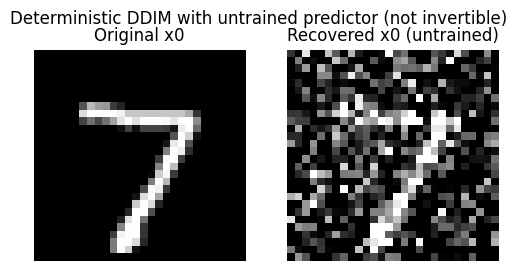

In [8]:
# Python: try reconstructing using the untrained predictor (it will fail)
with torch.no_grad():
    x_current = x_T.clone()
    for idx in reversed(range(1, t_T+1)):
        t = idx
        t_prev = idx - 1
        eps_pred = pred_model(x_current)  # untrained model's predicted noise
        x_prev, x0_hat = ddim_step_deterministic(x_current, eps_pred, t, t_prev)
        x_current = x_prev

    x0_pred_recon = x_current
    diff_untrained = (x0_pred_recon - x0).abs().max().item()
    print("Max abs difference original x0 vs reconstructed (untrained predictor):", diff_untrained)

    # show images
    orig = (x0.cpu().squeeze().numpy() + 1) / 2
    rec_un = (x0_pred_recon.cpu().squeeze().numpy() + 1) / 2
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(orig, cmap='gray', vmin=0, vmax=1); plt.title('Original x0'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(rec_un, cmap='gray', vmin=0, vmax=1); plt.title('Recovered x0 (untrained)'); plt.axis('off')
    plt.suptitle('Deterministic DDIM with untrained predictor (not invertible)')
    plt.show()


Collected trajectory 'oracle' shape: (49, 784)
Collected trajectory 'untrained' shape: (49, 784)


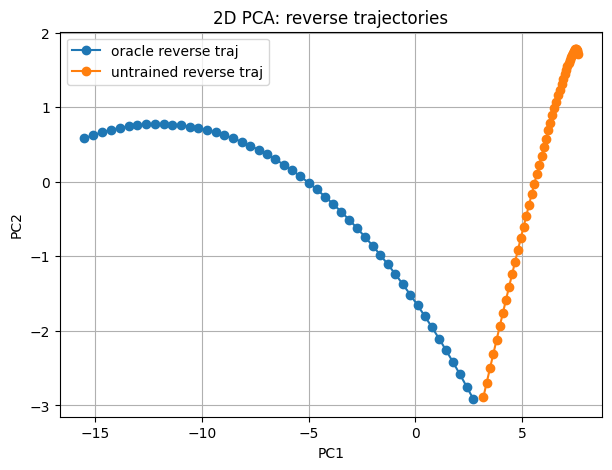

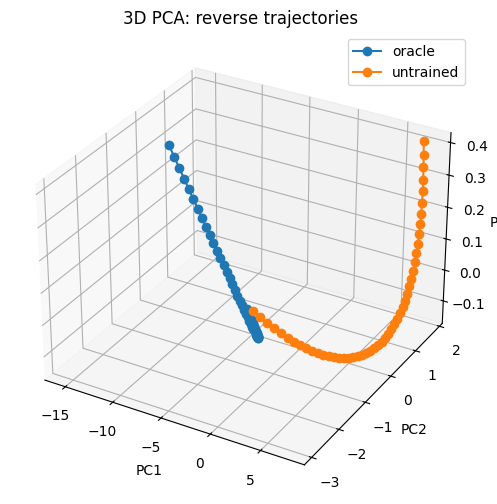

In [10]:
# Python: collect flattened vectors along the reverse path for oracle and untrained
def collect_reverse_trajectory(xT, eps_provider, label):
    x = xT.clone()
    traj = []
    for idx in reversed(range(1, t_T+1)):
        t = idx
        t_prev = idx - 1

        eps_pred = eps_provider(x, t)   # function gives eps_t
        x_prev, x0_hat = ddim_step_deterministic(x, eps_pred, t, t_prev)

        # ---- FIX: detach before numpy ----
        traj.append(x_prev.detach().cpu().numpy().reshape(-1))

        x = x_prev

    traj = np.stack(traj)  # (steps, features)
    print(f"Collected trajectory '{label}' shape:", traj.shape)
    return traj


# eps providers
def eps_oracle_provider(x_curr, t):
    return eps_used.to(x_curr.device)  # oracle uses same noise for all t

def eps_pred_provider(x_curr, t):
    return pred_model(x_curr)          # untrained model


# Collect trajectories
traj_oracle = collect_reverse_trajectory(x_T, eps_oracle_provider, "oracle")
traj_untrained = collect_reverse_trajectory(x_T, eps_pred_provider, "untrained")

# PCA
combined = np.vstack([traj_oracle, traj_untrained])
pca = PCA(n_components=3)
proj = pca.fit_transform(combined)

n_steps = traj_oracle.shape[0]
proj_or = proj[:n_steps]
proj_un = proj[n_steps:]


# 2D PCA plot
plt.figure(figsize=(7,5))
plt.plot(proj_or[:,0], proj_or[:,1], '-o', label='oracle reverse traj')
plt.plot(proj_un[:,0], proj_un[:,1], '-o', label='untrained reverse traj')
plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA: reverse trajectories')
plt.grid(True)
plt.show()


# 3D PCA plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(proj_or[:,0], proj_or[:,1], proj_or[:,2], '-o', label='oracle')
ax.plot(proj_un[:,0], proj_un[:,1], proj_un[:,2], '-o', label='untrained')
ax.legend()
ax.set_title('3D PCA: reverse trajectories')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.show()


# Summary and practical notes

1. The DDIM family gives a general non-Markovian reverse sampler; DDPM is one special choice of $\sigma_t$.
2. When $\sigma_t=0$ (deterministic DDIM), and when the noise predictor is exact, the reverse mapping is **uniquely invertible**: forward $x_0\to x_T$ and deterministic reverse $x_T\to x_0$ recover the original sample.
3. For editing applications: deterministically invert an image to $x_T$, modify conditioning (e.g., class/text), and map back deterministically — the invertibility preserves parts of the sample that are independent of conditioning.
4. In practice $\epsilon_\theta$ must be trained (commonly a U-Net with timestep conditioning). The notebook used an oracle to *demonstrate the invertibility property* and an untrained model to show the contrast.
5. DDIM can speed up sampling by using fewer steps; deterministic variants permit consistent manipulations across samplings.
